<a href="https://colab.research.google.com/github/ncgomez17/Deep_Learning/blob/master/Keras/Aprendiendo_Keras7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este ejemplo vamos a probar una Red GAN(**Generative Adversarial Networks**)

In [42]:
import tensorflow as tf
from tensorflow import keras
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import time
## Hay que asegurarse que estemos usando una GPU ya que los calculos serás costosos
!nvidia-smi

Mon Mar 22 00:26:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    288MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [43]:
## Descargamos las imágenes del cojunto de datos del MNIST
(train_images,_), (_,_) = keras.datasets.mnist.load_data()

##En este caso solo nos interesan las imágenes por lo que las etiquetas y los datos para testear no nos harán falta

train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')

In [45]:
## Preparamos los datos
train_images = (train_images -127.5) /127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256
noise_dim = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [46]:
## Creación de los modelos: Generador y Discriminador

from keras import Sequential
from keras.layers import Dense,Reshape,Conv2DTranspose,BatchNormalization,LeakyReLU,Conv2D,Flatten

def generator_model():

  model = Sequential()
  model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))

  model.add(Reshape((7,7,256)))
  model.add(Conv2DTranspose(128,(5,5),strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2DTranspose(64,(5,5),strides=(1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2DTranspose(1,(5,5),strides=(2,2), padding='same'))

  return model

generator = generator_model()

generator.summary()
  

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 64)       

In [47]:
## Generamos el modelo del Discriminador

def discriminator_model():
  model = Sequential()
  model.add(Conv2D(32,(5,5),strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(64,(5,5),strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(128,(5,5),strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))

  return model

discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         204928    
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 4, 128)        

In [49]:
## Establecemos funciones de pérdida y optimizadores

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real,fake):
  real_loss = cross_entropy(tf.ones_like(real),real)

  fake_loss = cross_entropy(tf.zeros_like(fake),fake)

  total_loss = real_loss + fake_loss

  return total_loss


def generator_loss(fake):

  return cross_entropy(tf.ones_like(fake),fake)


discriminator_optimizer = keras.optimizers.Adam(1e-4)

generator_optimizer = keras.optimizers.Adam(1e-4)

In [62]:
grid_size_x = 10
grid_size_y = 10
seed = tf.random.normal([grid_size_x*grid_size_y,noise_dim])

@tf.function
def train_step(images):

  noise = tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    generated_images = generator(noise,training=True)

    real_output = discriminator(images,training=True)
    fake_output = discriminator(generated_images,training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss,
                                           generator.trainable_variables)

  gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                           discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



def generate_images(model,test_input):

  predictions = model(test_input,training= False)
  fig = plt.figure(figsize=(grid_size_x,grid_size_y))
  for i in range(predictions.shape[0]):
    plt.subplot(grid_size_x,grid_size_y,i+1)
    plt.imshow(predictions[i, :, :,0] * 127.5 +127.5, cmap='gray')
    plt.axis('off')
  plt.show()

def train(dataset,epochs):

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    generate_images(generator,seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  generate_images(generator, seed)


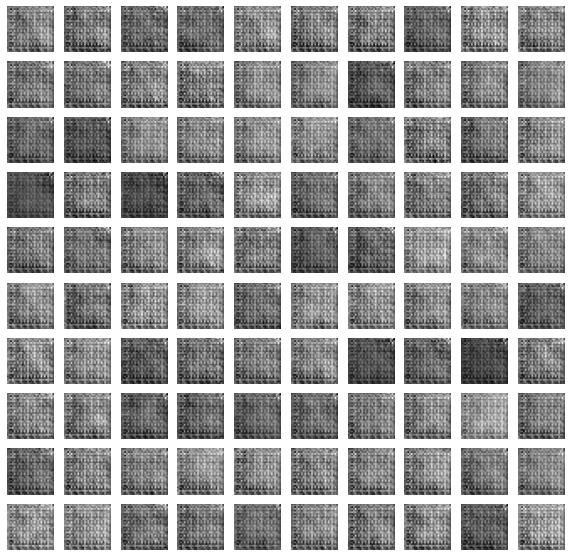

Time for epoch 1 is 18.504980087280273 sec


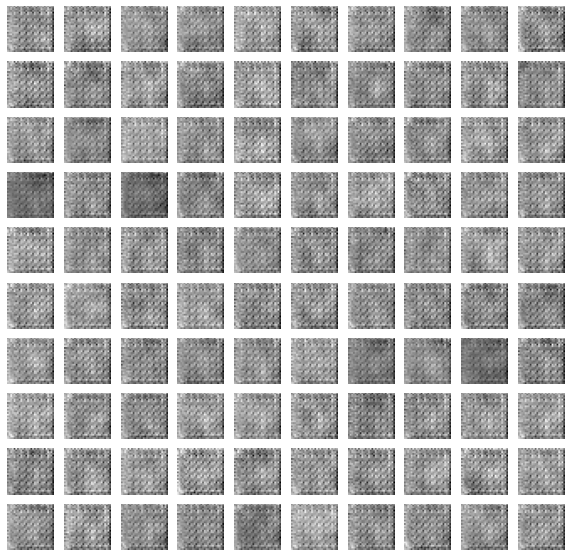

Time for epoch 2 is 17.854530572891235 sec


In [ ]:
## Visualizamos los resultados

train(train_dataset,50)